In [93]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas.plotting import register_matplotlib_converters

#Want to see all columns!
pd.set_option('display.max_columns', None)

register_matplotlib_converters()

In [94]:
file_tag = 'drought'
filename = 'datasets/drought'
target = 'class'

In [95]:
data=pd.read_csv(filename+'.csv', na_values='?', low_memory=False)

In [96]:
data.drop('date', axis='columns', inplace=True)

# Outlier Removal

In [74]:
#fig=plt.figure(figsize=(40, 10))
#data.boxplot()

In [75]:
from pandas import DataFrame
from ds_charts import get_variable_types

OUTLIER_PARAM: int = 1.5 # define the number of stdev to use or the IQR scale (usually 1.5)
OPTION = 'iqr'  # or 'stdev'

def determine_outlier_thresholds(summary5: DataFrame, var: str):
    if 'iqr' == OPTION:
        iqr = OUTLIER_PARAM * (summary5[var]['75%'] - summary5[var]['25%'])
        top_threshold = summary5[var]['75%']  + iqr
        bottom_threshold = summary5[var]['25%']  - iqr
    else:  # OPTION == 'stdev'
        std = OUTLIER_PARAM * summary5[var]['std']
        top_threshold = summary5[var]['mean'] + std
        bottom_threshold = summary5[var]['mean'] - std
    return top_threshold, bottom_threshold

numeric_vars = get_variable_types(data)['Numeric']
if [] == numeric_vars:
    raise ValueError('There are no numeric variables.')
print('Original data:', data.shape)
summary5 = data.describe(include='number')
df = data.copy(deep=True)
for var in numeric_vars:
    top_threshold, bottom_threshold = determine_outlier_thresholds(summary5, var)
    outliers = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
    df.drop(outliers.index, axis=0, inplace=True)
print('data after dropping outliers:', df.shape)

Original data: (59429, 51)
data after dropping outliers: (15948, 51)


In [76]:
data=df

# Scaling

In [100]:
from ds_charts import get_variable_types

variable_types = get_variable_types(data)
numeric_vars = variable_types['Numeric']
symbolic_vars = variable_types['Symbolic']
boolean_vars = variable_types['Binary']

df_nr = data[numeric_vars]
df_sb = data[symbolic_vars]
df_bool = data[boolean_vars]

In [101]:
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, concat

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=data.index, columns= numeric_vars)
norm_data_zscore = concat([tmp, df_sb,  df_bool], axis=1)

In [102]:
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=data.index, columns= numeric_vars)
norm_data_minmax = concat([tmp, df_sb,  df_bool], axis=1)

In [108]:
data=norm_data_zscore

In [109]:
import numpy as np
from pandas import read_csv, concat, unique, DataFrame
import matplotlib.pyplot as plt
import ds_charts as ds
from sklearn.model_selection import train_test_split

def split():
    target = 'class'
    positive = 1
    negative = 0
    values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

    y: np.ndarray = data.pop(target).values
    X: np.ndarray = data.values
    labels: np.ndarray = unique(y)
    labels.sort()

    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    train = concat([DataFrame(trnX, columns=data.columns), DataFrame(trnY,columns=[target])], axis=1)
    train.to_csv(f'datasets/{file_tag}_train.csv', index=False)

    test = concat([DataFrame(tstX, columns=data.columns), DataFrame(tstY,columns=[target])], axis=1)
    test.to_csv(f'datasets/{file_tag}_test.csv', index=False)
    values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
    values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

    plt.figure(figsize=(12,4))
    ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
    plt.show()

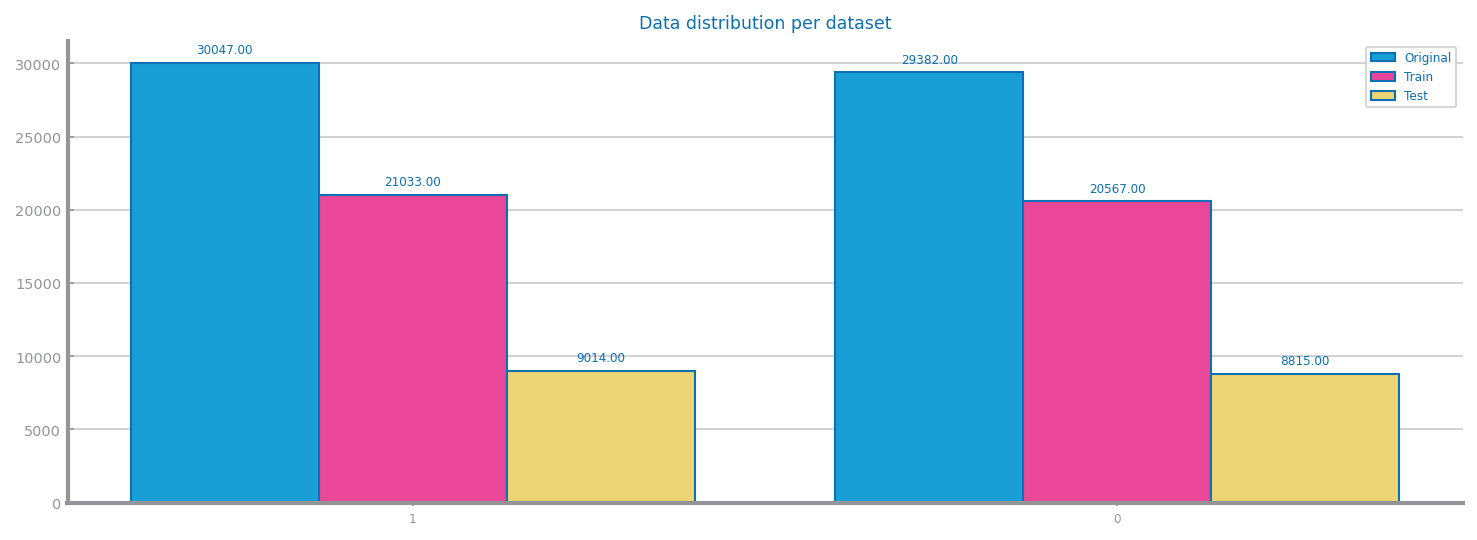

In [110]:
split()

# NAÏVE BAYES

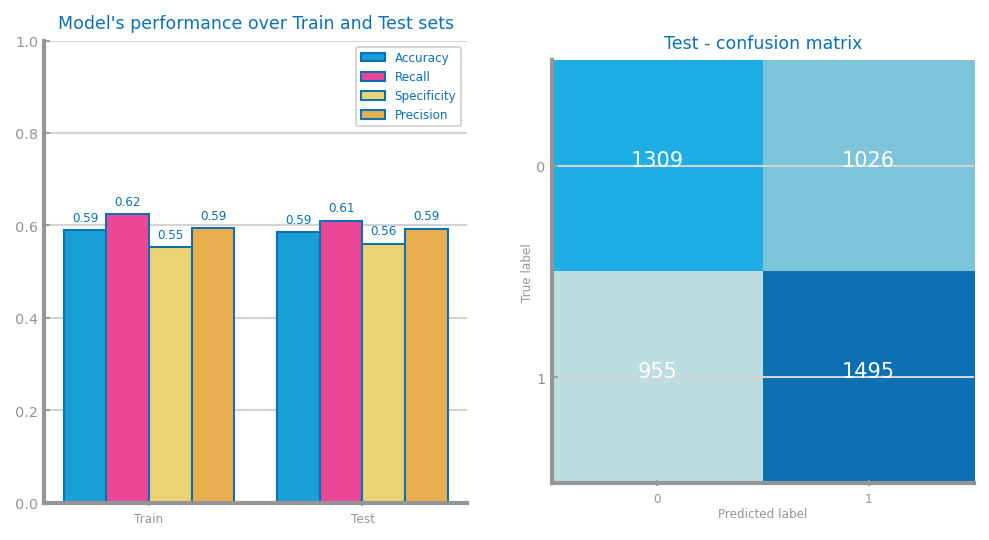

In [69]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, savefig, show
from sklearn.naive_bayes import GaussianNB
from ds_charts import plot_evaluation_results, bar_chart

train: DataFrame = read_csv(f'{filename}_train.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv(f'{filename}_test.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
show()

# KNN

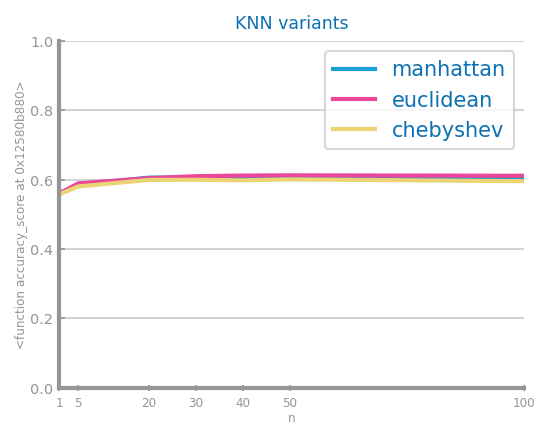

Best results with 50 neighbors and euclidean


In [111]:
from numpy import ndarray
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, savefig, show
from sklearn.neighbors import KNeighborsClassifier
from ds_charts import plot_evaluation_results, multiple_line_chart, plot_overfitting_study
from sklearn.metrics import accuracy_score

train: DataFrame = read_csv(f'{filename}_train.csv')
trnY: ndarray = train.pop(target).values
trnX: ndarray = train.values
labels = unique(trnY)
labels.sort()

test: DataFrame = read_csv(f'{filename}_test.csv')
tstY: ndarray = test.pop(target).values
tstX: ndarray = test.values

eval_metric = accuracy_score
nvalues = [1, 5, 20, 30, 40, 50, 100]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    y_tst_values = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prd_tst_Y = knn.predict(tstX)
        y_tst_values.append(eval_metric(tstY, prd_tst_Y))
        if y_tst_values[-1] > last_best:
            best = (n, d)
            last_best = y_tst_values[-1]
    values[d] = y_tst_values

figure()
multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel=str(accuracy_score), percentage=True)
show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

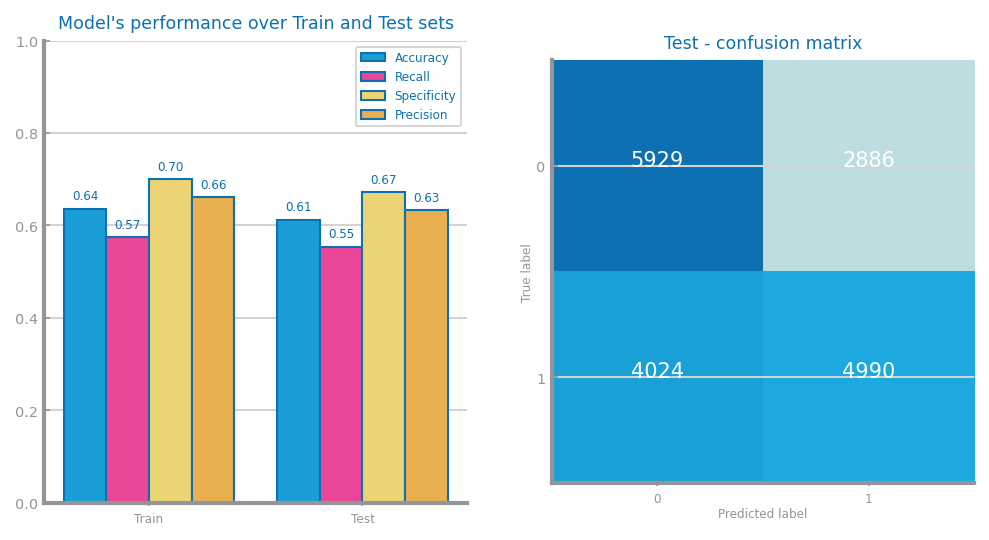

In [112]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
#savefig('images/{file_tag}_knn_best.png')
show()